In [3]:
import os
import numpy as np
import pandas as pd
from nilearn import datasets, image, masking, connectome
from nilearn.input_data import NiftiLabelsMasker
import matplotlib.pyplot as plt

In [4]:
# Set your data folder
data_dir = "/home/nilayoh/swm_fmri_data"  # change this to your actual path
subject_files = sorted([f for f in os.listdir(data_dir) if f.endswith('brain.nii.gz')])

In [5]:
# Load an atlas (AAL or Harvard-Oxford for MNI space)
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps
labels = atlas.labels

[get_dataset_dir] Dataset found in /home/nilayoh/nilearn_data/aal_SPM12

In [6]:
# Initialize masker: extracts time series from each ROI
masker = NiftiLabelsMasker(labels_img=atlas_filename,
                           standardize=True, detrend=True,
                           low_pass=None, high_pass=None, t_r=2.0)  # Adjust TR if needed

In [ ]:

# Extract subject IDs assuming the format 'sub-XX_brain.nii.gz'
subject_ids = [f.split('_')[0] for f in subject_files]

# Map each subject ID to their corresponding DVARS confound file
confound_files = {sid: os.path.join(data_dir, f"{sid}_DVARS_vals.txt") for sid in subject_ids}


In [ ]:

connectivity_matrices = []

for subj_file in subject_files:
    subj_path = os.path.join(data_dir, subj_file)
    subject_id = subj_file.split('_')[0]
    confound_path = confound_files.get(subject_id)

    print(f"Processing {subj_file}")

    # Load confound (e.g., DVARS values)
    confounds = None
    if confound_path and os.path.exists(confound_path):
        confounds = pd.read_csv(confound_path, header=None, delim_whitespace=True)

    # Extract ROI time series with confound regression
    time_series = masker.fit_transform(subj_path, confounds=confounds)

    # Compute correlation matrix
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
    corr_matrix = correlation_measure.fit_transform([time_series])[0]

    connectivity_matrices.append(corr_matrix)


In [7]:
# Save results to disk
np.save("connectivity_matrices.npy", connectivity_matrices)

NameError: name 'connectivity_matrices' is not defined

In [8]:
import numpy as np

# Load the saved connectivity matrices
connectivity_matrices = np.load("connectivity_matrices.npy")

In [9]:
# Convert to NumPy array (N_subjects x N_ROIs x N_ROIs)
connectivity_matrices = np.array(connectivity_matrices)

# Optional: average matrix across subjects
group_mean_matrix = np.mean(connectivity_matrices, axis=0)

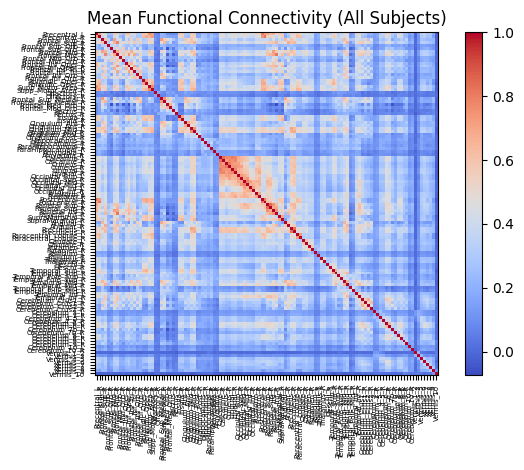

In [10]:
# Plot mean matrix
plt.imshow(group_mean_matrix, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.title('Mean Functional Connectivity (All Subjects)')
plt.xticks(range(len(labels)), labels, fontsize=5, rotation=90)
plt.yticks(range(len(labels)), labels, fontsize=5)
plt.tight_layout()
plt.show()

In [11]:
# Get indices for frontal and parietal ROIs
frontal_indices = [i for i, label in enumerate(labels) if 'Frontal' in label or 'Precentral' in label]
parietal_indices = [i for i, label in enumerate(labels) if 'Parietal' in label or 'Postcentral' in label]

print("Frontal ROIs:", [labels[i] for i in frontal_indices])
print("Parietal ROIs:", [labels[i] for i in parietal_indices])
# Extract frontal-parietal connectivity for each subject
fp_connectivity = connectivity_matrices[:, :, :][:, frontal_indices][:, :, parietal_indices]

# fp_connectivity shape: (n_subjects, n_frontal, n_parietal)
print("Shape of frontoparietal data:", fp_connectivity.shape)

# Save for later
np.save("frontoparietal_connectivity.npy", fp_connectivity)

Frontal ROIs: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R']
Parietal ROIs: ['Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R']
Shape of frontoparietal data: (68, 20, 6)


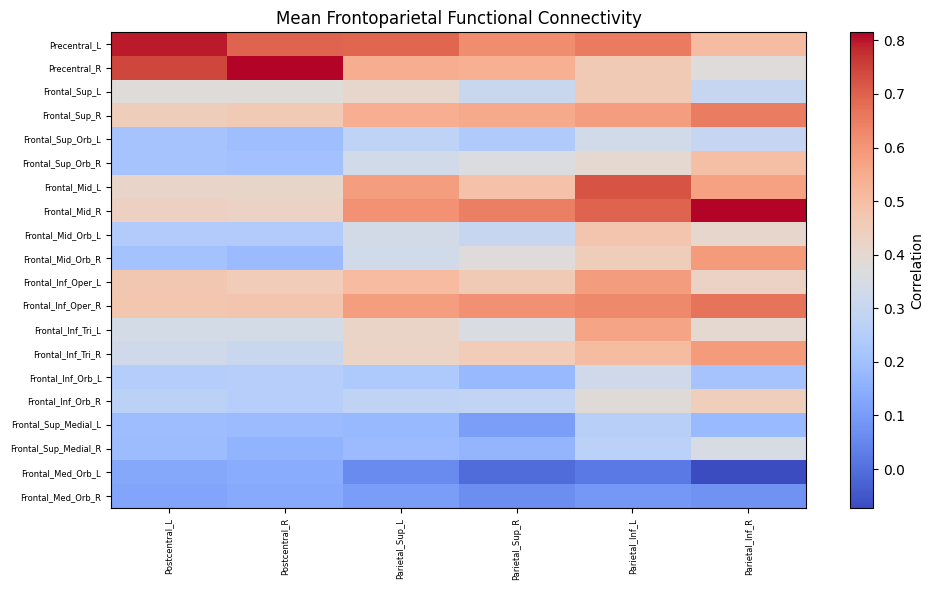

In [12]:
mean_fp = np.mean(fp_connectivity, axis=0)  # shape: (n_frontal, n_parietal)

plt.figure(figsize=(10, 6))
plt.imshow(mean_fp, cmap='coolwarm', aspect='auto')
plt.colorbar(label="Correlation")
plt.title("Mean Frontoparietal Functional Connectivity")
plt.xticks(range(len(parietal_indices)), [labels[i] for i in parietal_indices], rotation=90, fontsize=6)
plt.yticks(range(len(frontal_indices)), [labels[i] for i in frontal_indices], fontsize=6)
plt.tight_layout()
plt.show()

In [13]:
# Load groups.csv
groups_df = pd.read_csv("groups.csv")

# Extract just subject IDs from filenames
subject_ids = [f.split('_')[0] for f in subject_files]

# Match group labels to subjects
groups_df = groups_df.set_index('ID')
subject_groups = [groups_df.loc[s, 'group'] for s in subject_ids]

# Convert to numpy array
subject_groups = np.array(subject_groups)

In [14]:
# Convert connectivity to numpy if not already
fp_conn = np.load("frontoparietal_connectivity.npy")  # or use your in-memory variable

# Find group indices
adhd_idx = np.where(subject_groups == 'ADHD')[0]
ctrl_idx = np.where(subject_groups == 'Control')[0]

# Split data
fp_adhd = fp_conn[adhd_idx]     # shape: (n_adhd, n_frontal, n_parietal)
fp_ctrl = fp_conn[ctrl_idx]     # shape: (n_ctrl, n_frontal, n_parietal)

In [15]:
from scipy.stats import ttest_ind

n_f, n_p = fp_conn.shape[1:3]
t_vals = np.zeros((n_f, n_p))
p_vals = np.zeros((n_f, n_p))

for i in range(n_f):
    for j in range(n_p):
        t, p = ttest_ind(fp_adhd[:, i, j], fp_ctrl[:, i, j])
        t_vals[i, j] = t
        p_vals[i, j] = p

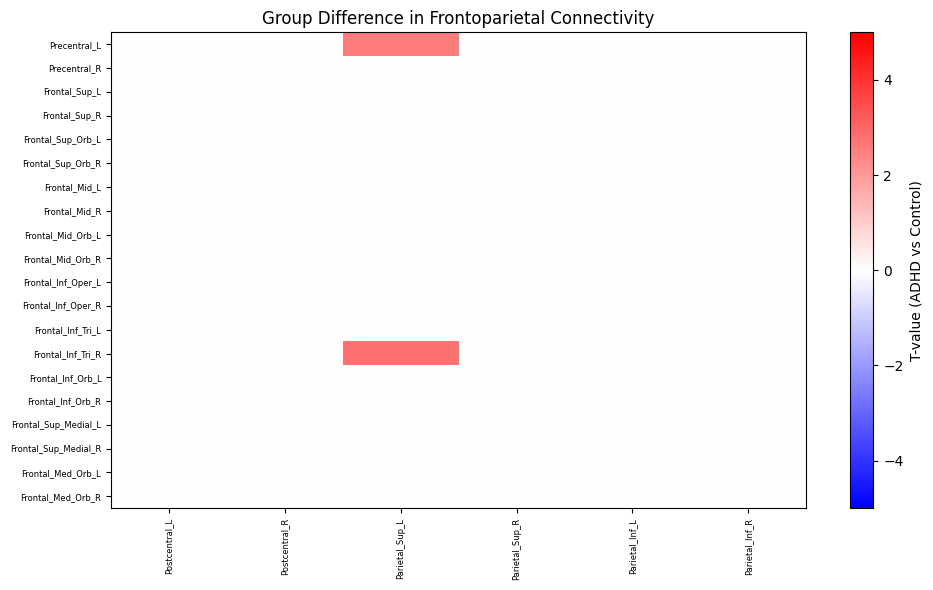

In [16]:
# Optional: Threshold by p-value (e.g., p < 0.05 uncorrected)
significant_mask = p_vals < 0.05

plt.figure(figsize=(10, 6))
plt.imshow(t_vals * significant_mask, cmap='bwr', aspect='auto', vmin=-5, vmax=5)
plt.colorbar(label="T-value (ADHD vs Control)")
plt.title("Group Difference in Frontoparietal Connectivity")

plt.xticks(range(n_p), [labels[i] for i in parietal_indices], rotation=90, fontsize=6)
plt.yticks(range(n_f), [labels[i] for i in frontal_indices], fontsize=6)

plt.tight_layout()
plt.show()

In [17]:
import numpy as np

# Average FP connectivity per subject: mean over frontal × parietal dimensions
fp_adhd_avg = fp_adhd.mean(axis=(1, 2))   # shape: (n_adhd,)
fp_ctrl_avg = fp_ctrl.mean(axis=(1, 2))   # shape: (n_ctrl,)

# Print group-level means and standard deviations
print("ADHD group - mean FP connectivity:", fp_adhd_avg.mean(), "±", fp_adhd_avg.std())
print("Control group - mean FP connectivity:", fp_ctrl_avg.mean(), "±", fp_ctrl_avg.std())

ADHD group - mean FP connectivity: 0.38335684 ± 0.13230598
Control group - mean FP connectivity: 0.37404302 ± 0.12855603


In [18]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(fp_adhd_avg, fp_ctrl_avg)
print(f"T-test: t = {t_stat:.3f}, p = {p_val:.3f}")

T-test: t = 0.286, p = 0.776


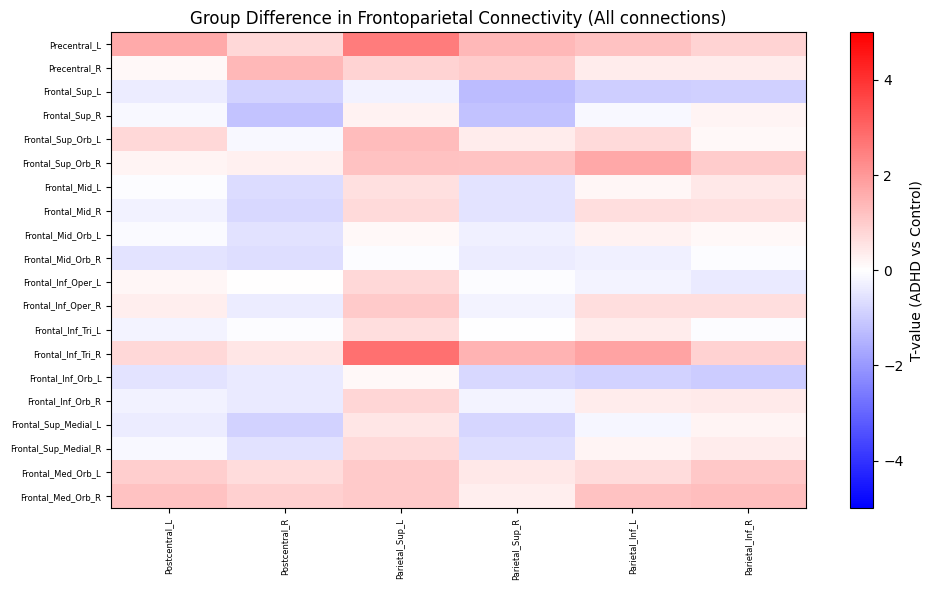

In [19]:
plt.figure(figsize=(10, 6))
plt.imshow(t_vals, cmap='bwr', aspect='auto', vmin=-5, vmax=5)  # Show all t-values
plt.colorbar(label="T-value (ADHD vs Control)")
plt.title("Group Difference in Frontoparietal Connectivity (All connections)")

plt.xticks(range(n_p), [labels[i] for i in parietal_indices], rotation=90, fontsize=6)
plt.yticks(range(n_f), [labels[i] for i in frontal_indices], fontsize=6)

plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import nibabel as nib
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.image import math_img
from nilearn.regions import connected_regions
from nilearn import plotting
import matplotlib.pyplot as plt

# Fetch Schaefer atlas (100 ROIs as example)
atlas = fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_img = atlas['maps']
atlas_nii = nib.load(atlas_img)
atlas_data = atlas_nii.get_fdata()

# Compute centroid for each region
coords = []
for region_id in range(1, 101):  # Schaefer labels start from 1
    region_mask = (atlas_data == region_id)
    coords_vox = np.argwhere(region_mask)
    coords_mni = nib.affines.apply_affine(atlas_nii.affine, coords_vox)
    centroid = coords_mni.mean(axis=0)
    coords.append(centroid)
coords = np.array(coords)


[get_dataset_dir] Dataset found in /home/nilayoh/nilearn_data/schaefer_2018

In [21]:
rng = np.random.default_rng(seed=42)
connectivity_matrix = rng.random((100, 100))
connectivity_matrix = (connectivity_matrix + connectivity_matrix.T) / 2  # Symmetrize
np.fill_diagonal(connectivity_matrix, 0)

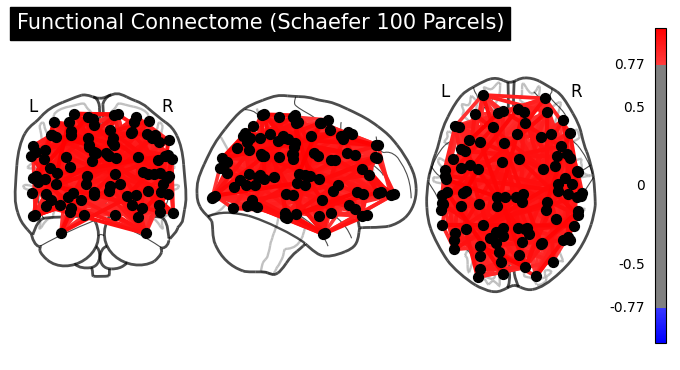

In [22]:
plotting.plot_connectome(connectivity_matrix, coords,
                         edge_threshold='90%',
                         node_color='black',
                         colorbar=True,
                         title="Functional Connectome (Schaefer 100 Parcels)")
plt.show()

In [23]:
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import load_img
import nibabel as nib

# Load Schaefer atlas (e.g., 100-region, 7-network)
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_filename = atlas.maps
labels = atlas.labels

# Get coordinates of each region
from nilearn import plotting
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

[get_dataset_dir] Dataset found in /home/nilayoh/nilearn_data/schaefer_2018

In [24]:
groups_df = pd.read_csv("groups.csv")  # Ensure this file has columns 'ID' and 'group'
groups_df = groups_df.set_index('ID')  # Use 'ID' as the index

# Suppose you have subject IDs from filenames
subject_ids = [f.split('_')[0] for f in subject_files]  # or however you extract them

# Now map subject IDs to their group labels
subject_groups = np.array([groups_df.loc[s, 'group'] for s in subject_ids], dtype=str)

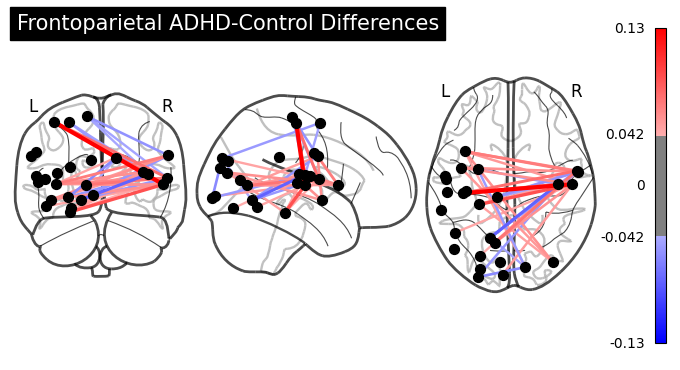

In [25]:
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt

# Load saved frontoparietal connectivity if not already loaded
fp_conn = np.load("frontoparietal_connectivity.npy")
subject_groups = np.array([groups_df.loc[s, 'group'] for s in subject_ids], dtype=str)
# Find group indices
adhd_idx = np.where(subject_groups == 'ADHD')[0]
ctrl_idx = np.where(subject_groups == 'Control')[0]

# Split data
fp_adhd = fp_conn[adhd_idx]   # shape: (n_adhd, n_frontal, n_parietal)
fp_ctrl = fp_conn[ctrl_idx]   # shape: (n_ctrl, n_frontal, n_parietal)

# Compute mean connectivity for each group
mean_adhd = np.mean(fp_adhd, axis=0)
mean_ctrl = np.mean(fp_ctrl, axis=0)

# Compute difference matrix
diff_matrix = mean_adhd - mean_ctrl

# Zero out diagonals if needed (not needed for rectangular matrix)
# Optional: flatten to square if frontal == parietal
# e.g., square_diff = np.zeros((n, n)); square_diff[np.ix_(frontal, parietal)] = diff_matrix

# ----- Coordinates for nodes -----
# Get node coordinates for frontal and parietal ROIs
coords_all = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)
coords_frontal = [coords_all[i] for i in frontal_indices]
coords_parietal = [coords_all[i] for i in parietal_indices]
coords = coords_frontal + coords_parietal

# Combine matrix into square for plotting
n_f = len(frontal_indices)
n_p = len(parietal_indices)
connectivity_square = np.zeros((n_f + n_p, n_f + n_p))
connectivity_square[:n_f, n_f:] = diff_matrix  # upper right: frontal to parietal
connectivity_square[n_f:, :n_f] = diff_matrix.T  # lower left: parietal to frontal

# Plot connectome
plotting.plot_connectome(connectivity_square, coords,
                         edge_threshold='90%',
                         title="Frontoparietal ADHD-Control Differences",
                         colorbar=True,
                         node_color='black')
plt.show()

In [26]:
plotting.view_connectome(connectivity_square, coords, edge_threshold='98%',
                        edge_cmap='viridis')

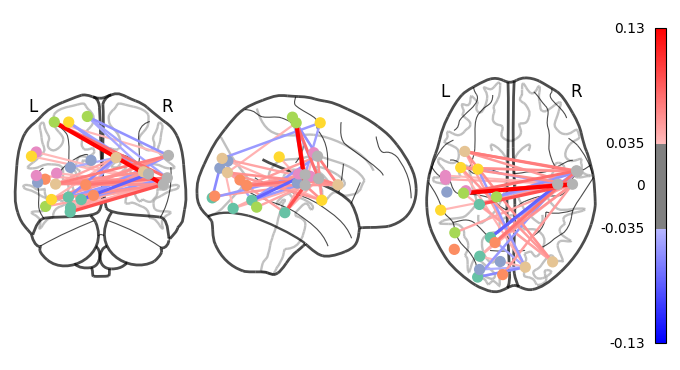

In [27]:
plotting.plot_connectome(connectivity_square, coords, colorbar=True, edge_threshold=0.035)

In [28]:
coords_all = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)

In [29]:
alpha = 0.05
sig_mask = p_vals < alpha

In [30]:
sig_diff_matrix = np.zeros_like(diff_matrix)
sig_diff_matrix[sig_mask] = diff_matrix[sig_mask]

In [31]:
sign_connectivity_square = np.zeros((n_f + n_p, n_f + n_p))
sign_connectivity_square[:n_f, n_f:] = sig_diff_matrix           # upper-right: frontal to parietal
sign_connectivity_square[n_f:, :n_f] = sig_diff_matrix.T         # lower-left: parietal to frontal

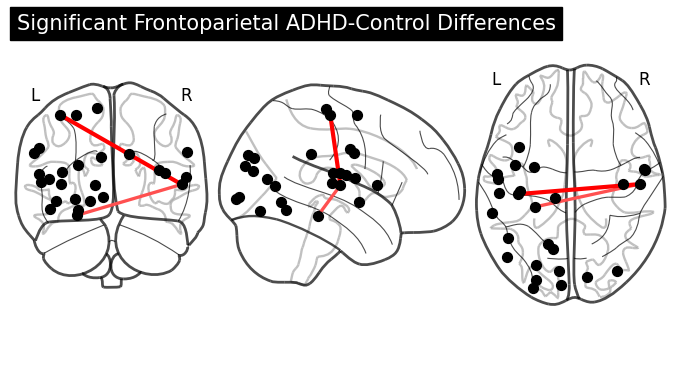

In [32]:
plotting.plot_connectome(sign_connectivity_square, coords,
                         edge_threshold=1e-6,  # shows all non-zero entries
                         title="Significant Frontoparietal ADHD-Control Differences",
                         node_color='black')
plt.show()

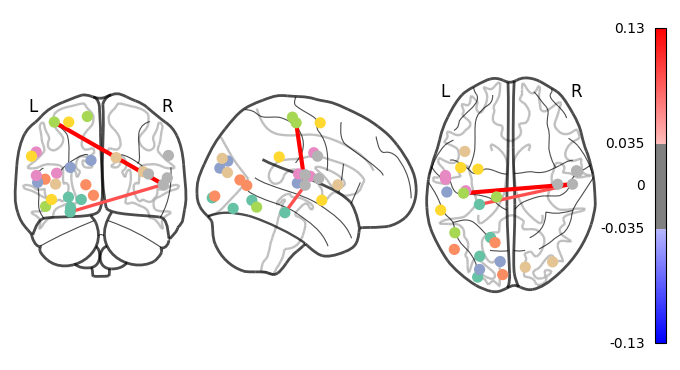

In [33]:
plotting.plot_connectome(sign_connectivity_square, coords, colorbar=True, edge_threshold=0.035)

In [34]:
plotting.view_connectome(sign_connectivity_square, coords, edge_threshold='98%',
                        edge_cmap='viridis')

In [35]:
from statsmodels.stats.multitest import fdrcorrection

In [36]:
p_flat = p_vals.flatten()
_, p_fdr = fdrcorrection(p_flat, alpha=0.05)
p_fdr_matrix = p_fdr.reshape(p_vals.shape)

In [37]:
sig_mask_fdr = p_fdr_matrix < 0.05

In [38]:
sig_diff_matrix = np.zeros_like(diff_matrix)
sig_diff_matrix[sig_mask_fdr] = diff_matrix[sig_mask_fdr]

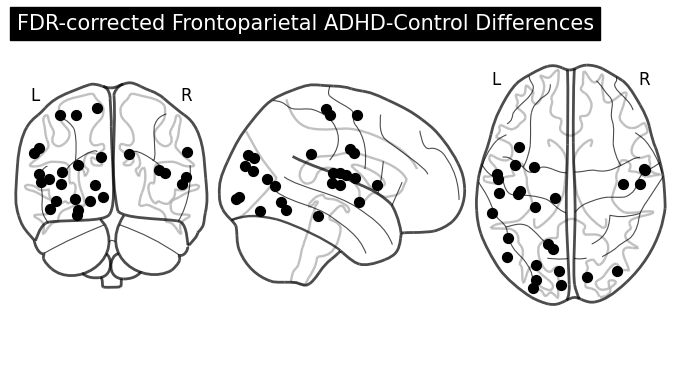

In [41]:
connectivity_square_fdr = np.zeros((n_f + n_p, n_f + n_p))
connectivity_square_fdr[:n_f, n_f:] = sig_diff_matrix
connectivity_square_fdr[n_f:, :n_f] = sig_diff_matrix.T

# Plot FDR-corrected connectome
plotting.plot_connectome(connectivity_square_fdr, coords,
                         edge_threshold='80%',
                         title="FDR-corrected Frontoparietal ADHD-Control Differences",
                         node_color='black')
plt.show()